In [1]:
import dgl
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
c:\users\esysss\appdata\local\programs\python\python37\lib\site-packages\dgl\base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)


In [2]:
weight_matrix = np.genfromtxt('m.csv', delimiter=',')
weight_matrix.shape

(82, 82)

In [3]:
network = nx.from_numpy_matrix(weight_matrix)

In [4]:
scr = np.array([i[0] for i in network.edges])
des = np.array([i[1] for i in network.edges])

G = dgl.DGLGraph((scr, des))

c:\users\esysss\appdata\local\programs\python\python37\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [5]:
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 82 nodes.
We have 1255 edges.


c:\users\esysss\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


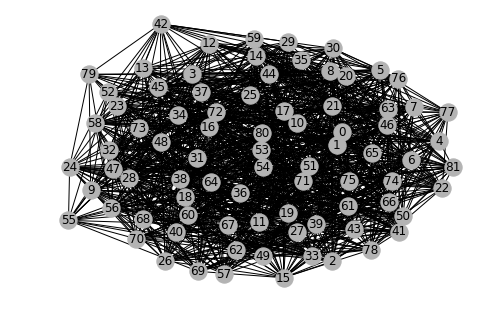

In [6]:
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

weights = torch.Tensor([i[2]['weight'] for i in list(network.edges(data = True))])
G.edata['w'] = weights
G.edata

{'w': tensor([2.4221e+00, 3.7106e-02, 1.5418e-01,  ..., 2.2770e+00, 2.7697e-03,
        3.0930e+00])}

In [61]:
embed = nn.Embedding(82, 5)  # 82 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [102]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of outputs.
net = GCN(5, 5, 2)

In [103]:
inputs = embed.weight
labeled_nodes = torch.tensor(range(1,len(network)))
labels = torch.LongTensor(np.concatenate([np.zeros(37),np.ones(82-38)]))

In [104]:
print(labeled_nodes)
print(len(labeled_nodes))

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
        73, 74, 75, 76, 77, 78, 79, 80, 81])
81


In [105]:
print(labels)
print(len(labels))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])
81


In [106]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(300):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6825
Epoch 1 | Loss: 0.6747
Epoch 2 | Loss: 0.6652
Epoch 3 | Loss: 0.6531
Epoch 4 | Loss: 0.6399
Epoch 5 | Loss: 0.6258
Epoch 6 | Loss: 0.6114
Epoch 7 | Loss: 0.5972
Epoch 8 | Loss: 0.5832
Epoch 9 | Loss: 0.5694
Epoch 10 | Loss: 0.5559
Epoch 11 | Loss: 0.5428
Epoch 12 | Loss: 0.5299
Epoch 13 | Loss: 0.5174
Epoch 14 | Loss: 0.5053
Epoch 15 | Loss: 0.4936
Epoch 16 | Loss: 0.4822
Epoch 17 | Loss: 0.4711
Epoch 18 | Loss: 0.4601
Epoch 19 | Loss: 0.4490
Epoch 20 | Loss: 0.4379
Epoch 21 | Loss: 0.4268
Epoch 22 | Loss: 0.4156
Epoch 23 | Loss: 0.4046
Epoch 24 | Loss: 0.3936
Epoch 25 | Loss: 0.3823
Epoch 26 | Loss: 0.3709
Epoch 27 | Loss: 0.3594
Epoch 28 | Loss: 0.3477
Epoch 29 | Loss: 0.3359
Epoch 30 | Loss: 0.3242
Epoch 31 | Loss: 0.3126
Epoch 32 | Loss: 0.3011
Epoch 33 | Loss: 0.2899
Epoch 34 | Loss: 0.2789
Epoch 35 | Loss: 0.2682
Epoch 36 | Loss: 0.2576
Epoch 37 | Loss: 0.2474
Epoch 38 | Loss: 0.2376
Epoch 39 | Loss: 0.2282
Epoch 40 | Loss: 0.2191
Epoch 41 | Loss: 0.2104
Ep

c:\users\esysss\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


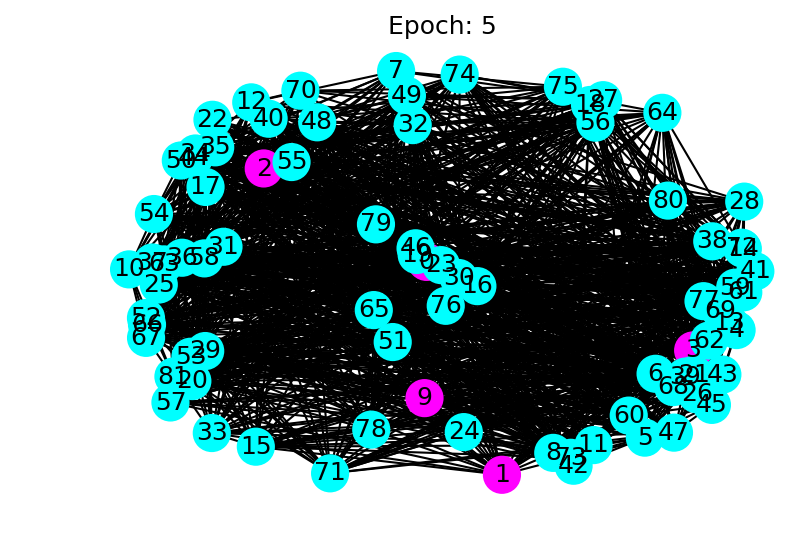

In [112]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

layer = nx.spring_layout(network)
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(82):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos = layer, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(5)  # draw the prediction of the first epoch
plt.show()
plt.close()

In [113]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
ani.save('basic_animation.gif', fps=10, extra_args=['-vcodec', 'libx264'])

MovieWriter ffmpeg unavailable. Trying to use pillow instead.
c:\users\esysss\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [109]:
all_logits[290][81].numpy().argmax()

1

In [110]:
all_logits[290][0].numpy().argmax()

0

In [111]:
logits.detach().argmax(axis = 1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [130]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=82,shuffle=True)

X = np.arange(82)
y = np.array(logits.detach().argmax(axis = 1))
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index,"\n")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [132]:
kf.get_n_splits(X)

82